In [1]:
import os
import glob
import json
import tifffile 
import numpy 

from matplotlib import pyplot
from skimage import filters, measure
from collections import defaultdict
from tqdm.auto import tqdm

from stedfm.DEFAULTS import BASE_PATH
from stedfm.utils import savefig

TEMPLATE = "template-factin-assemblies"
COLORS = {
    "Block" : "tab:blue",
    "0Mg" : "tab:green",
    "KCl" : "tab:orange",
    "Glu-Gly" : "tab:purple"
}

with open(os.path.join(BASE_PATH, "results", "detection-experiments", "MAE_SMALL_STED", TEMPLATE , "metadata.json")) as f:
    metadata = json.load(f)

for key, values in metadata.items():
    print(key, len(values))

Block 86
0Mg 70
KCl 83
Glu-Gly 48


In [2]:
def get_dendrite_foreground(img):
    """Gets the foreground of the dendrite channel using a gaussian blur of
    sigma = 20 and the otsu threshold.

    :param img: A 3D numpy

    :returns : A binary 2D numpy array of the foreground
    """
    blurred = filters.gaussian(img[2], sigma=20)
    blurred /= blurred.max()
    val = filters.threshold_otsu(blurred)
    return (blurred > val).astype(int)

def validate_rprop_in_foreground(rprop, foreground):
    """
    Validates that the region properties are touching the foreground.

    :param rprops: A list of region properties
    :param foreground: A binary 2D numpy array of the foreground
    """
    coords = rprop.coords
    if numpy.any(foreground[coords[:, 0], coords[:, 1]] == 1):
        return True
    return False

def label_image_from_rprops(rprops, shape):
    """
    Creates a labeled image from region properties.

    :param rprops: A list of region properties
    :param shape: The shape of the image

    :returns : A labeled image
    """
    label = numpy.zeros(shape, dtype=int)
    for i, rprop in enumerate(rprops):
        coords = rprop.coords
        label[coords[:, 0], coords[:, 1]] = i + 1
    return label

def load_images(metadata, show=False):
    """
    Loads the images and optionaly displays them.

    :param metadata: A dictionary with the metadata
    :param show: A boolean to display

    :returns : A tuple with the foreground and the labeled image
    """
    original = tifffile.imread(os.path.join(BASE_PATH, metadata["original-path"]))
    foreground = get_dendrite_foreground(original)

    prediction = tifffile.imread(os.path.join(BASE_PATH, metadata["savepath"]))[1]
    binarized = (prediction > 0.65).astype(int)

    label = measure.label(binarized)
    rprops = measure.regionprops(label)
    rprops = [rprop for rprop in rprops if validate_rprop_in_foreground(rprop, foreground)]
    label = label_image_from_rprops(rprops, binarized.shape)

    if show:
        fig, axes = pyplot.subplots(1, 4, figsize=(10, 5))
        axes[0].imshow(original[0])
        axes[1].imshow(foreground)
        axes[2].imshow(prediction, cmap="magma", vmin=0.65, vmax=0.8)
        axes[3].imshow(label)
        pyplot.show()

    return foreground, label

def compute_scores(foreground, label):
    """
    Computes the scores for the foreground and the label.

    :param foreground: A binary 2D numpy array of the foreground
    :param label: A labeled image

    :returns : A dictionary with the scores
    """
    return {
        "ratio" : numpy.count_nonzero(label) / numpy.count_nonzero(foreground)
    }



Block:   0%|          | 0/86 [00:00<?, ?it/s]

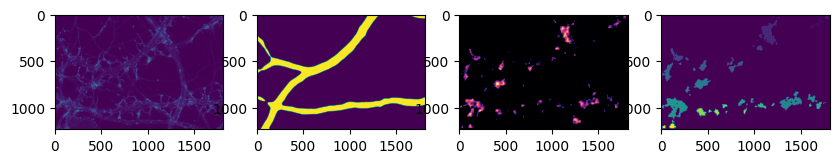

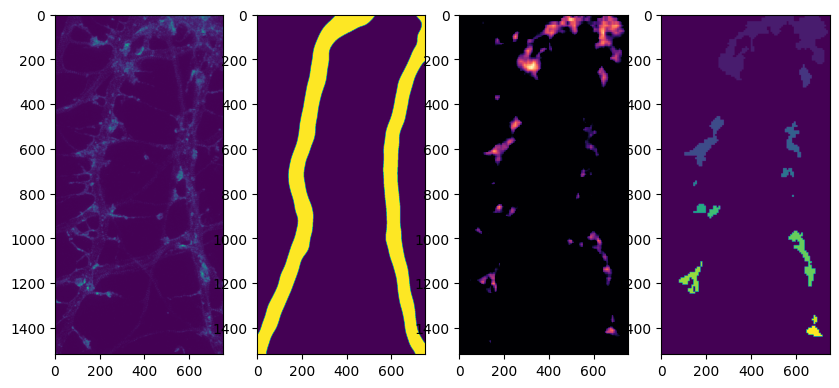

0Mg:   0%|          | 0/70 [00:00<?, ?it/s]

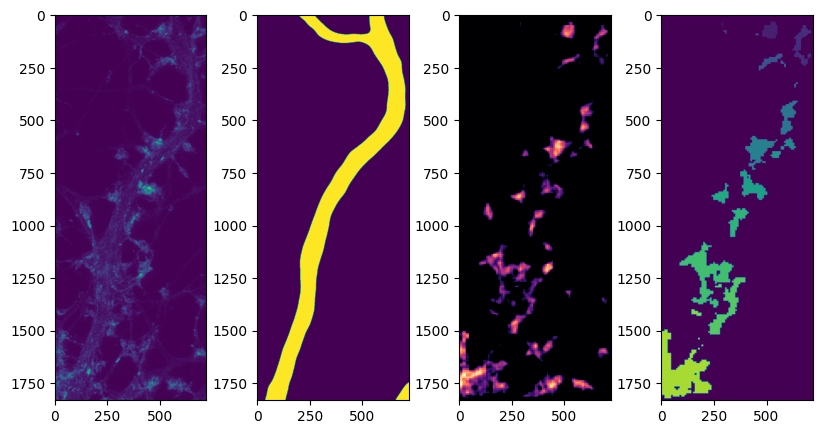

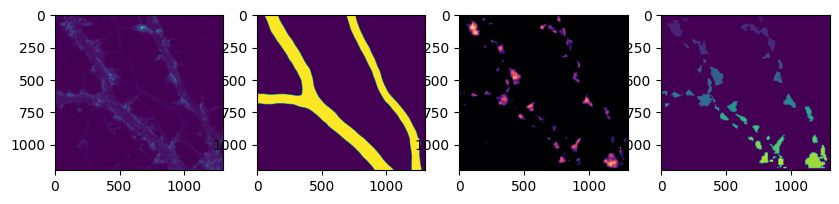

KCl:   0%|          | 0/83 [00:00<?, ?it/s]

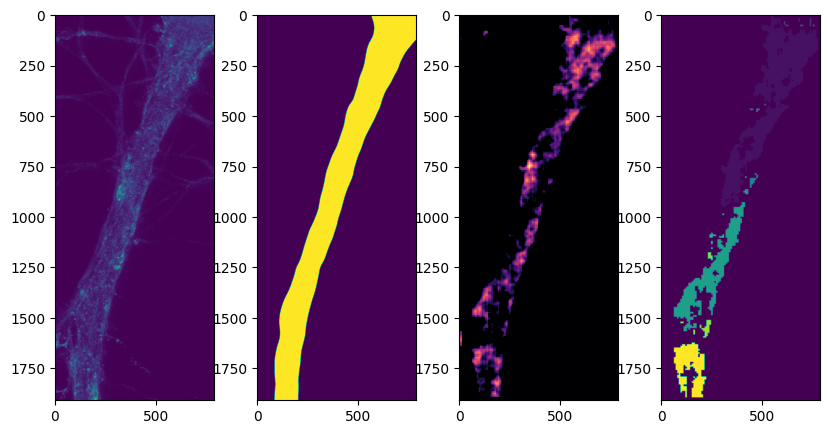

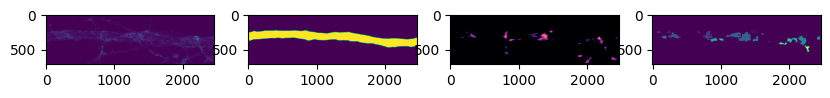

Glu-Gly:   0%|          | 0/48 [00:00<?, ?it/s]

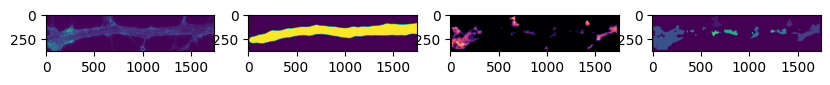

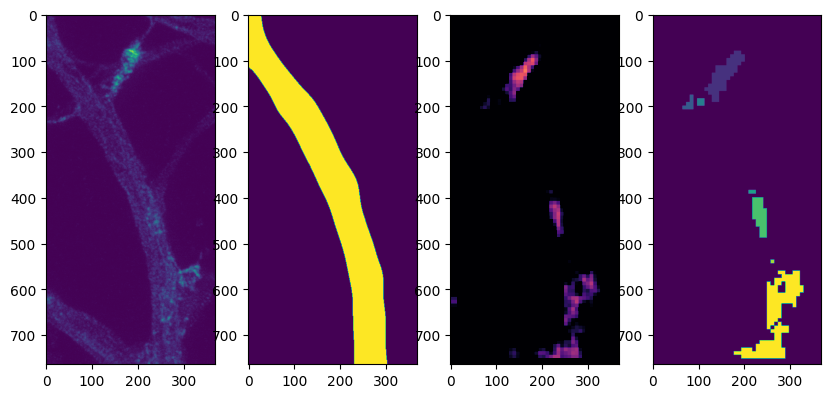

In [3]:
scores = defaultdict(list)
for condition, metadata_per_condition in metadata.items():
    for i, metadata_per_image in enumerate(tqdm(metadata_per_condition, desc=condition)):
        foregound, label = load_images(metadata_per_image, show=i<2)

        score = compute_scores(foregound, label)
        scores[condition].append(score)

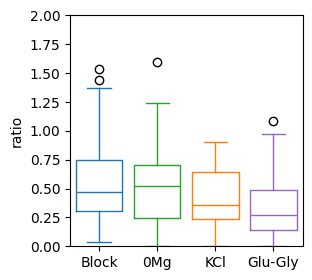

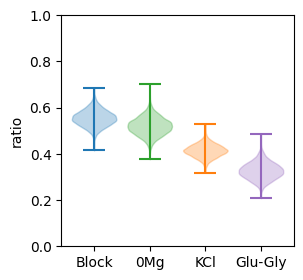

In [4]:
def plot_raw_scores(scores, name="ratio"):
    """
    Plots the scores.

    :param scores: A dictionary with the scores
    """
    fig, ax = pyplot.subplots(1, 1, figsize=(3, 3))
    for i, (condition, values) in enumerate(scores.items()):
        ratios = [value[name] for value in values]
        bplot = ax.boxplot(ratios, positions=[i], widths=0.8)
        for _, parts in bplot.items():
            for part in parts:
                part.set_color(COLORS[condition])
    ax.set(
        xticks=list(range(len(scores))),
        xticklabels=list(scores.keys()),
        ylabel=name,
        ylim=(0, 2.0)
    )
    pyplot.show()

def bootstrap(samples, N=10000):
    """
    Computes the bootstrap scores.

    :param samples: A list of samples
    :param N: The number of bootstrap samples

    :returns : A list of bootstrap scores
    """
    choices = numpy.random.choice(samples, (N, len(samples)))
    return numpy.mean(choices, axis=1)

def plot_bootstrap_scores(scores, name="ratio", N=10000):
    """
    Plots the bootstrap scores.

    :param scores: A dictionary with the scores
    :param N: The number of bootstrap samples
    """
    fig, ax = pyplot.subplots(1, 1, figsize=(3, 3))
    for i, (condition, values) in enumerate(scores.items()):
        ratios = [value[name] for value in values]
        bootstrapped = bootstrap(ratios, N=N)
        bplot = ax.violinplot(bootstrapped, positions=[i], widths=0.8)
        for _, parts in bplot.items():
            if isinstance(parts, list):
                for part in parts:
                    part.set_color(COLORS[condition])
            else:
                parts.set_color(COLORS[condition])
    ax.set(
        xticks=list(range(len(scores))),
        xticklabels=list(scores.keys()),
        ylabel=name,
        ylim=(0., 1.0)
    )
    savefig(fig, "./panels/factin-patches/bootstrap-ratios", save_white=True)
    pyplot.show()

plot_raw_scores(scores)
plot_bootstrap_scores(scores)

Block
Sample size: 86
0Mg
Sample size: 70
KCl
Sample size: 83
Glu-Gly
Sample size: 48


  0%|          | 0/6 [00:00<?, ?it/s]

P-values:           Block     0Mg     KCl  Glu-Gly
Block   -1.0000  0.5052  0.0023   0.0000
0Mg      0.5052 -1.0000  0.0244   0.0004
KCl      0.0023  0.0244 -1.0000   0.0534
Glu-Gly  0.0000  0.0004  0.0534  -1.0000
F-values: 0.0002


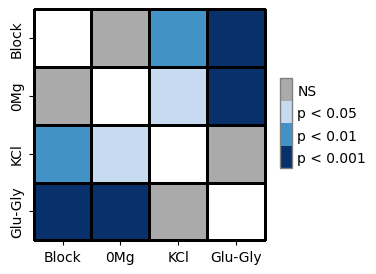

In [9]:
# Stats
from stedfm.stats import resampling_stats, plot_p_values

samples = [[value["ratio"] for value in values] for condition, values in scores.items()]
for name, sample in zip(scores.keys(), samples):
    print(name,)
    print("Sample size:", len(sample))
labels = list(scores.keys())

p_values, F_p_values = resampling_stats(samples, labels)
print("P-values:", p_values)
print("F-values:", F_p_values)
fig, ax = plot_p_values(p_values)
savefig(fig, "./panels/factin-patches/stats", save_white=True)

Block
0.6065329719713085 0.006532971971308532
11_Block_DIV13_SMI31-STAR580_MAP2-STAR488_PhSTAR635_3.msr_STED640_Conf561_Conf488_merged.tif


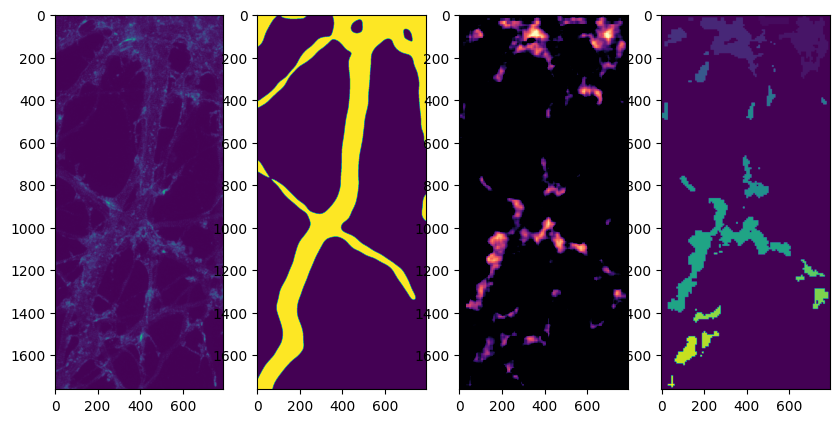

0.5903954610083474 0.00960453899165259
11_Block_DIV13_SMI31-STAR580_MAP2-STAR488_PhSTAR635_6.msr_STED640_Conf561_Conf488_merged.tif


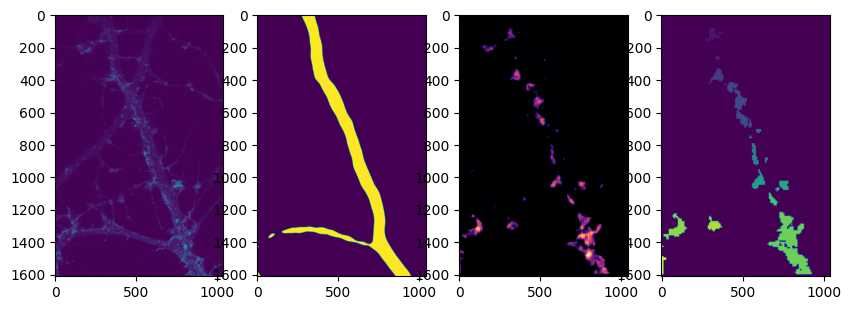

0.5818876087902105 0.01811239120978947
04_Block_SMI31-STAR580_MAP2-STAR488_PhSTAR635_5.msr_STED640_Conf561_Conf488_merged.tif


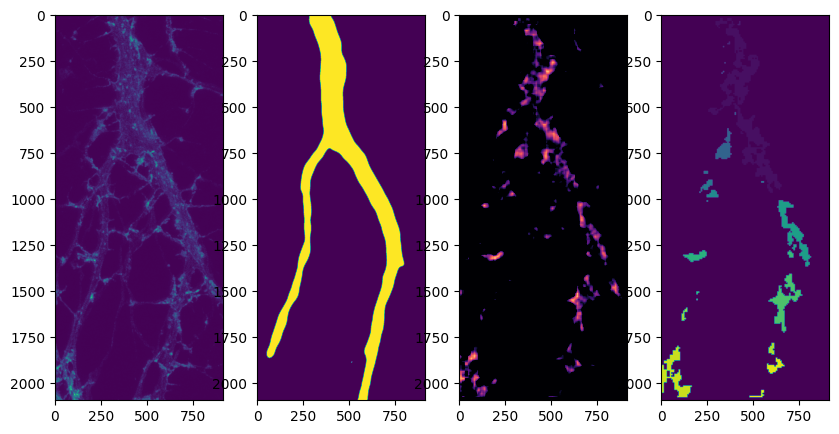

0.5810486837140342 0.018951316285965802
12_Block_10_SMI31-STAR580_MAP2-STAR488_PhSTAR635_10.msr_STED640_Conf561_Conf488_merged.tif


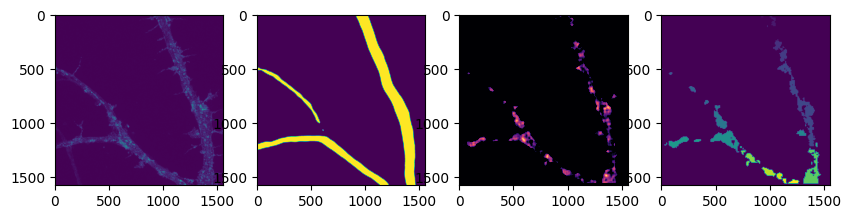

0.6224567554829247 0.022456755482924695
01_Block_DIV13_10_SMI31-STAR580_MAP2-STAR488_PhSTAR635_6.msr_STED640_Conf561_Conf488_merged.tif


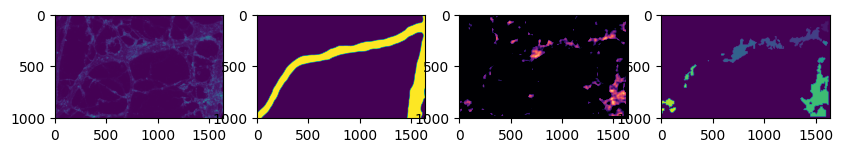

Glu-Gly
0.29904375543320777 0.0009562445667922193
08-DIV13-Glu-Gly_SMI31_S580-MAP2-S488_PhS635_02a.msr_STED640_Conf561_Conf488_merged.tif


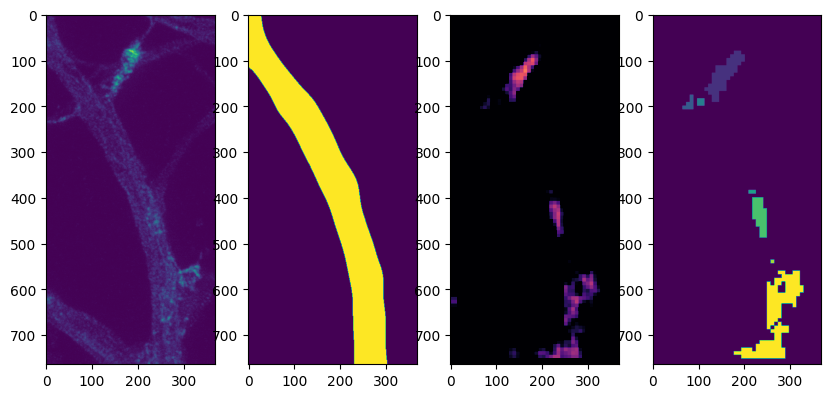

0.29881859127030913 0.0011814087296908582
03_Glu-Gly_SMI31-STAR580_MAP2-STAR488_PhSTAR635_10.msr_STED640_Conf561_Conf488_merged.tif


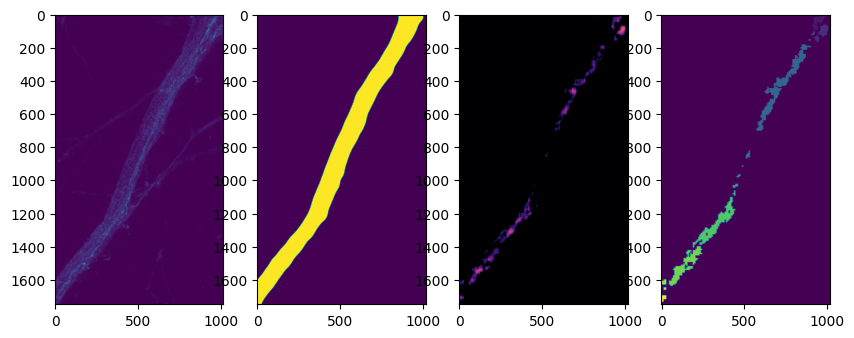

0.2837634638186138 0.016236536181386207
11_Glu-Gly_SMI31-STAR580_MAP2-STAR488_PhSTAR635_1.msr_STED640_Conf561_Conf488_merged.tif


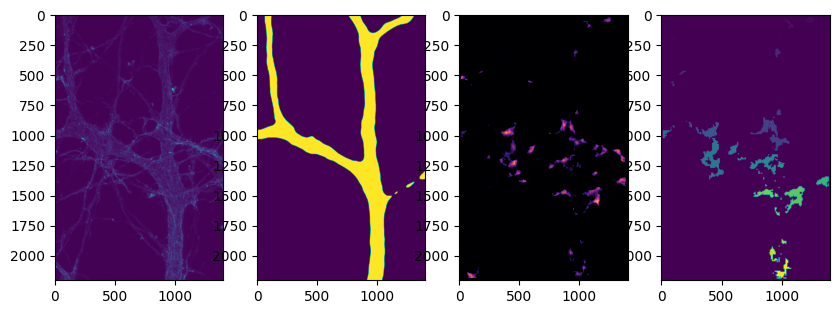

0.28372574544634527 0.01627425455365472
08-DIV13-Glu-Gly_SMI31_S580-MAP2-S488_PhS635_04a.msr_STED640_Conf561_Conf488_merged.tif


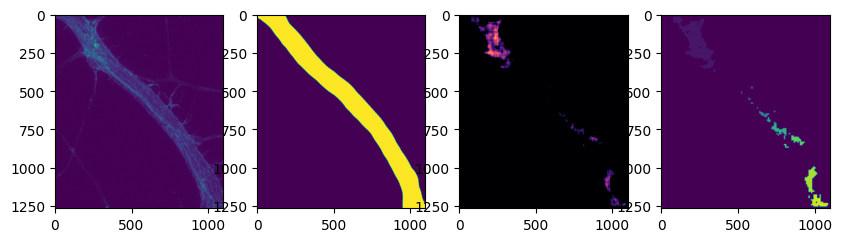

0.32553429909948833 0.025534299099488345
08-DIV13-Glu-Gly_SMI31_S580-MAP2-S488_PhS635_06a.msr_STED640_Conf561_Conf488_merged.tif


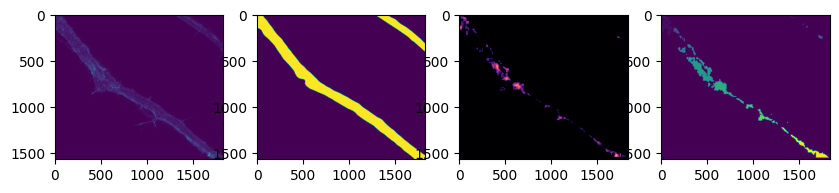

In [ ]:
# Find possible examples to display

print("Block")

VALUE = 0.6
values = numpy.array([value["ratio"] for value in scores["Block"]])
differences = numpy.abs(values - VALUE)
argsorted = numpy.argsort(differences)

for i in argsorted[:5]:
    print(values[i], differences[i])
    print(metadata["Block"][i]["image-name"])
    fg, lbl = load_images(metadata["Block"][i], show=True)

    tifffile.imwrite(f"./panels/factin-patches/{metadata['Block'][i]['image-name']}", fg.astype(numpy.uint8) * 255)

print("Glu-Gly")

VALUE = 0.3
values = numpy.array([value["ratio"] for value in scores["Glu-Gly"]])
differences = numpy.abs(values - VALUE)
argsorted = numpy.argsort(differences)

for i in argsorted[:5]:
    print(values[i], differences[i])
    print(metadata["Glu-Gly"][i]["image-name"])
    fg, lbl = load_images(metadata["Glu-Gly"][i], show=True)

    tifffile.imwrite(f"./panels/factin-patches/{metadata['Block'][i]['image-name']}", fg.astype(numpy.uint8) * 255)